**Importing all the needed dependencies**

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [22]:
# Loading the dataset into a pandas dataframe
data = pd.read_csv("/content/chennai_bus_delay_prediction.csv")

In [23]:
# Preprocessing the time features
def parse_time(time_str):
    return datetime.strptime(time_str, "%I:%M %p")

In [24]:
# Parsing the original time columns
data["Scheduled_Time"] = data["Scheduled Time"].apply(parse_time)
data["Predicted_Arrival_Time"] = data["Predicted Arrival Time"].apply(parse_time)

In [25]:
# Calculating the time difference in minutes
data["Time_Diff_Minutes"] = (data["Predicted_Arrival_Time"] - data["Scheduled_Time"]).dt.total_seconds() / 60

In [26]:
# Encode categorical features
categorical_cols = ["Bus Number", "Route ID", "Starting Point", "Ending Point",
                    "Traffic Condition", "Reason for Delay", "Day of Week", "Weather Condition"]
data = pd.get_dummies(data, columns=categorical_cols)

In [27]:
# Target encoding
data["Incident_Detected"] = data["Incident Detected"].map({"Yes": 1, "No": 0})

In [28]:
data.head()

,Scheduled Time,Predicted Arrival Time,Delay (in Minutes),Incident Detected,Scheduled_Time,Predicted_Arrival_Time,Time_Diff_Minutes,Bus Number_102,Bus Number_21G,Bus Number_23C,...,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Weather Condition_Clear,Weather Condition_Foggy,Weather Condition_Rainy,Weather Condition_Stormy,Incident_Detected
0,02:57 PM,01:46 AM,6,No,1900-01-01 14:57:00,1900-01-01 01:46:00,-791.0,False,True,False,...,False,False,False,True,False,False,True,False,False,0
1,09:20 AM,05:15 AM,10,No,1900-01-01 09:20:00,1900-01-01 05:15:00,-245.0,False,False,False,...,True,False,False,False,False,True,False,False,False,0
2,11:11 PM,08:30 PM,22,No,1900-01-01 23:11:00,1900-01-01 20:30:00,-161.0,False,False,False,...,False,False,False,False,True,False,True,False,False,0
3,07:03 PM,06:40 AM,6,No,1900-01-01 19:03:00,1900-01-01 06:40:00,-743.0,False,False,True,...,False,False,False,False,False,True,False,False,False,0
4,02:31 AM,08:53 PM,7,No,1900-01-01 02:31:00,1900-01-01 20:53:00,1102.0,False,False,False,...,False,False,False,True,False,False,False,True,False,0


In [29]:
data.isnull().sum()

,0
Scheduled Time,0
Predicted Arrival Time,0
Delay (in Minutes),0
Incident Detected,0
Scheduled_Time,0
Predicted_Arrival_Time,0
Time_Diff_Minutes,0
Bus Number_102,0
Bus Number_21G,0
Bus Number_23C,0


In [30]:
# Splitting the Features and target
X = data.drop(columns=["Incident Detected", "Scheduled Time", "Predicted Arrival Time"])
y = data["Incident_Detected"]

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
# Scaling the numerical features
scaler = StandardScaler()
X_train[["Delay (in Minutes)", "Time_Diff_Minutes"]] = scaler.fit_transform(X_train[["Delay (in Minutes)", "Time_Diff_Minutes"]])
X_test[["Delay (in Minutes)", "Time_Diff_Minutes"]] = scaler.transform(X_test[["Delay (in Minutes)", "Time_Diff_Minutes"]])

In [35]:
# Extracting the useful features from datetime
X_train["Scheduled_Hour"] = X_train["Scheduled_Time"].dt.hour
X_train["Scheduled_Day"] = X_train["Scheduled_Time"].dt.day
X_train["Scheduled_Month"] = X_train["Scheduled_Time"].dt.month

X_train["Predicted_Hour"] = X_train["Predicted_Arrival_Time"].dt.hour
X_train["Predicted_Day"] = X_train["Predicted_Arrival_Time"].dt.day
X_train["Predicted_Month"] = X_train["Predicted_Arrival_Time"].dt.month

# Droping the original datetime columns
X_train.drop(["Scheduled_Time", "Predicted_Arrival_Time"], axis=1, inplace=True)

# Repeating the same for X_test
X_test["Scheduled_Hour"] = X_test["Scheduled_Time"].dt.hour
X_test["Scheduled_Day"] = X_test["Scheduled_Time"].dt.day
X_test["Scheduled_Month"] = X_test["Scheduled_Time"].dt.month

X_test["Predicted_Hour"] = X_test["Predicted_Arrival_Time"].dt.hour
X_test["Predicted_Day"] = X_test["Predicted_Arrival_Time"].dt.day
X_test["Predicted_Month"] = X_test["Predicted_Arrival_Time"].dt.month

X_test.drop(["Scheduled_Time", "Predicted_Arrival_Time"], axis=1, inplace=True)

In [36]:
# Train XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [44]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

In [49]:
# Printing the Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Confusion Matrix:
[[159   0]
 [  0  41]]


In [38]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 1.0000 ± 0.0000


In [46]:
# Visualizations
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(50.722222222222214, 0.5, 'Actual')

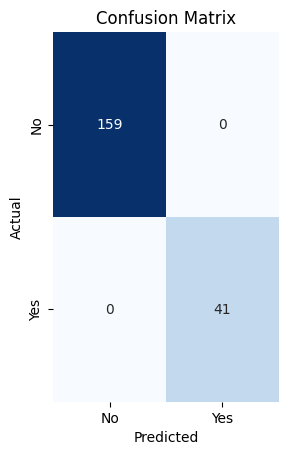

In [47]:
# 1. Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

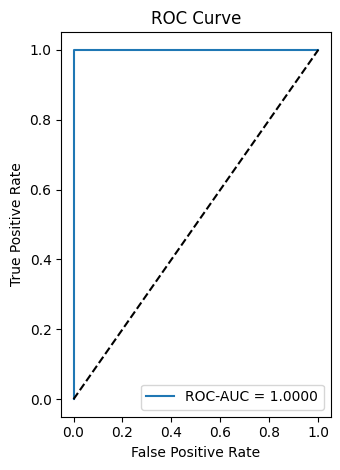

In [48]:
# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()